In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import quadrotor
import numpy as np
import matplotlib.pyplot as plt 
import math
import random
import scipy
import scipy.linalg
%matplotlib inline

importing Jupyter notebook from quadrotor.ipynb


In [2]:
m = quadrotor.MASS
l = quadrotor.LENGTH
I = quadrotor.INERTIA
g = quadrotor.GRAVITY
dt = quadrotor.DELTA_T


In [3]:
def get_linearization(z, u): 
    A = np.array([[1, dt, 0,                   0, 0, 0],
        [0, 1, 0, 0, -dt*(u[0]+u[1])*np.cos(z[4])/m, 0],
        [0, 0, 1,                             dt, 0, 0],
        [0, 0, 0, 1, -dt*(u[0]+u[1])*np.sin(z[4])/m, 0],
        [0, 0, 0,                             0, 1, dt],
        [0,0,0,                                 0,0,1]])
    
    B = np.array([[0, 0],
        [-np.sin(z[4])*dt/m, -np.sin(z[4])*dt/m],
        [0,                                   0],
        [np.cos(z[4])*dt/m,   np.cos(z[4])*dt/m],
        [0,                                   0],
        [l*dt/I,                       -l*dt/I]])
    return [A, B]

In [4]:
z_star = np.zeros([quadrotor.NUMBER_STATES,])
u_star = np.array([m*g/2,m*g/2])

In [5]:
# we can simulate the robot but we need to provide a controller of the following form
def dummy_controller(state, i):
    """
        the prototype of a controller is as follows
        state is a column vector containing the state of the robot
        i is the index corresponding to the time step in the horizon (useful to index gains K for e.g.)
        
        this controller needs to return an array of size (2,)
    """
    # here we do nothing and just return some non-zero control
    return 1. * np.ones([2,])




# we can now simulate for a given number of time steps - here we do 10 seconds
horizon_length = 1000
z0 = np.zeros([quadrotor.NUMBER_STATES,])
t, state, u = quadrotor.simulate(z0, dummy_controller, horizon_length, disturbance = False)

In [6]:
def compute_cost(z, u, horizon_length):
    J = 0
    for i in range(horizon_length):
        R = 1*np.identity(quadrotor.NUMBER_CONTROLS)
        if i<200:
            Q = np.diag([5, 2, 5, 2, 2, 2])
            z_des = np.array([0,0,0,0,0,0])
        elif i>200 and i<=500:
            Q = np.diag([200, 2, 200, 2, 200, 2])
            z_des = np.array([1.5, 0, 3, 0, np.pi, 0])
        elif i>500 and i<=600:
            Q = np.diag([100, 2, 100, 2, 200, 2])
            z_des = np.array([3, 0, 0, 0, 2*np.pi, 0])
        else:
            Q = np.diag([30, 2, 30, 2, 70, 2])
            z_des = np.array([3,0,0,0,2*np.pi,0])
            
        J = J + np.transpose((z[:,i] - z_des))@Q@(z[:,i] - z_des) + np.transpose((u[:,i] - u_star))@R@(u[:,i] - u_star)
    J = J + np.transpose((z[:,-1] - z_des))@Q@(z[:,-1] - z_des)
    return J

In [7]:
def solve_LQR_trajectory(A, B, Q, R,q,r,N):
    '''
    A, B, Q and R are the matrices defining the OC problem
    x_bar is the trajectory of desired states of size dim(x) x (N+1)
    N is the horizon length
    
    The function returns 1) a list of gains of length N and 2) a list of feedforward controls of length N
    '''

    P = []
    p = []
    k = []
    K = []
    
    for i in range(N+1):
        if i == 0:
            P.append(Q[-1])
            p.append(q[-1])
        else:
            Kn = -np.linalg.inv((np.transpose(B[i-1])@P[i-1]@B[i-1])+R[N-i])@(np.transpose(B[i-1])@P[i-1]@A[i-1])
            K.append(Kn)
            Pn = Q[N-i] + np.transpose(A[i-1])@P[i-1]@A[i-1] + np.transpose(A[i-1])@P[i-1]@B[i-1]@K[i-1]
            P.append(Pn)
            kn = -np.linalg.inv((np.transpose(B[i-1])@P[i-1]@B[i-1])+R[N-i])@(np.transpose(B[i-1])@p[i-1]+r[N-i])
            k.append(kn)
            pn = q[N-i] + np.transpose(A[i-1])@p[i-1] + np.transpose(A[i-1])@P[i-1]@B[i-1]@k[i-1]
            p.append(pn)
            
    K_gains = K[::-1]
    k_feedforward = k[::-1]
    
    return K_gains, k_feedforward

z_star = np.zeros([quadrotor.NUMBER_STATES,])
u_star = np.array([m*g/2,m*g/2])

In [8]:
def quadratic_approx(z, u, horizon_length):
    Q = [] 
    R = []
    q = [] 
    r = []
    A = []
    B = []
    for i in range(horizon_length):

        R_ = 1*np.identity(quadrotor.NUMBER_CONTROLS)
        
        if i<400:
            Q_ = np.diag([5, 2, 5, 2, 2, 2])
            z_des = np.array([0,0,0,0,np.pi,0])
        elif i>400 and i<=500:
            Q_ = np.diag([200, 2, 200, 2, 200, 2])
            z_des = np.array([1.5, 0, 3, 0, np.pi, 0])
#         elif i>500 and i<=600:
#             Q_ = np.diag([100, 2, 100, 2, 200, 2])
#             z_des = np.array([1.5, 0, 1.5, 0, 3*np.pi/4, 0])
        else:
            Q_ = np.diag( [30, 2, 30, 2, 70, 2])
            z_des =np.array([3, 0, 0, 0, 2*np.pi, 0])
            
        q_  = Q_@z[:,i] - Q_@z_des
        r_ = 2*R_@(u[:,i]-u_star) 
        A_, B_ = get_linearization(z[:,i], u[:,i])

        Q.append(Q_)
        R.append(R_)
        q.append(q_)
        r.append(r_)
        A.append(A_)
        B.append(B_)

    QN = np.diag([30, 2, 30, 2, 70, 2])
    Q.append(QN)

    qN = -QN@z[:,-1]
    q.append(qN)

    return Q, R, q, r, A, B

In [9]:
def iLQR(A, B, Q, R, q, r, z, u, N):
    K_gains = []
    k_feedforward = []
    Pn = []
    pn = []

    QN = Q[-1]
    qn = q[-1]

    Pn.append(QN)
    pn.append(qn)
      
    A.reverse()
    B.reverse()

    for i in range(horizon_length):
        Kn = - np.linalg.inv(np.transpose(B[i])@Pn[i]@B[i] + R[N-i-1])@np.transpose(B[i])@Pn[i]@A[i]
        K_gains.append(Kn)
        P_n = Q[N-i-2] + np.transpose(A[i])@Pn[i]@A[i]+ np.transpose(A[i])@Pn[i]@B[i]@Kn  
        Pn.append(P_n)
        kn =-np.linalg.inv(np.transpose(B[i])@Pn[i]@B[i] + R[N-i-1])@np.transpose(B[i])@pn[i] + r[N-i-1]
        k_feedforward.append(kn)
        p_n = q[N-i-2] + np.transpose(A[i])@pn[i] + np.transpose(A[i])@Pn[i]@B[i]@kn
        pn.append(p_n)
          
    K_gains.reverse()
    k_feedforward.reverse()
    return K_gains, k_feedforward

In [10]:
def new(z_star, u_star, Kt, kt, alpha, horizon_length):
    
    u = np.zeros_like(u_star)
    z = np.zeros_like(z_star)
    
    z[:,0] = np.array([0, 0, 0, 0, 0, 0])
    
    for i in range(horizon_length):
        u[:,i] = Kt[i]@(z[:,i]-z_star[:,i] ) + alpha*kt[i] + u_star[:,i]
        z[:,i+1] = quadrotor.get_next_state(z[:, i], u[:,i])

    u_star_new = u
    z_star_new = z
    
    return z_star_new, u_star_new

In [11]:
horizon_length = 1000


u = np.ones([quadrotor.NUMBER_CONTROLS, horizon_length])
z = np.zeros([quadrotor.NUMBER_STATES, horizon_length+1])

alpha = 1.0
for i in range(10):
    z[:,0] = z0
    for i in range(horizon_length):
        z[:, i+1] = quadrotor.get_next_state(z[:, i], u[:,i])
        
    J_old = compute_cost(z, u,horizon_length)
    
    Q, R, q, r, A, B = quadratic_approx(z, u, horizon_length)
   
    Kt, kt = iLQR(A, B, Q, R, q, r, z, u, horizon_length)      
    
    z_new, u_new = new(z, u, Kt, kt, alpha, horizon_length)
    
    J_new = compute_cost(z_new, u_new, horizon_length)
    #line search
    if J_new<J_old:
        J_old=J_new
    else:
        alpha = alpha/2
    u = u_new


Text(0.5, 0, 'Time [s]')

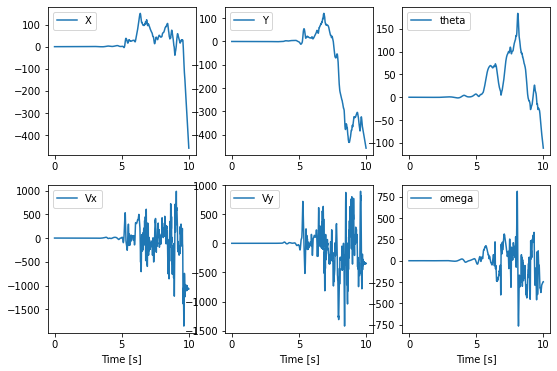

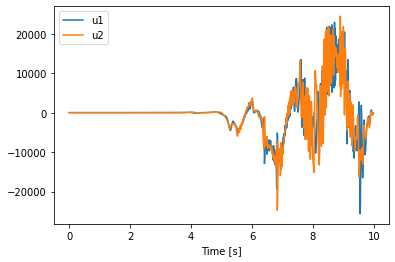

In [12]:
state = z_new
u = u_new

# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')


In [13]:
quadrotor.animate_robot(z, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAeddtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzA5NSBiYWVlNDAwIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DeRliIQAEf/+94gfMstp+TrXchHnrS6tH1DuRnFepL3+IAAAAwAAAwAA5Kr/b71mP6Kb4AAAFdAC
shIkDRqBfetCvEAVUOaOCT/9nLr9mTKx/UEGXNIx5yzRp1ThzPF1a7cBOfoeV9rWW9MlXAV4nPOB
K25SkyW06uB3fGJd5HI2KNBsDdIF+b9+/fdQbFwnGMNpmshlYl+wRIMZD7cH//6bE0/3g3vKyzpp
XTGBB3OqI+WPpR0oY73sOGMx594Xnwtr6o26ZSevIf/3ceGUyDxjmHduLhusOdOqEisdlAV6ah4c
jOy92ylo7wE2Fj/CQokXe2WWmda1xALK4NotBlvBUuGlTACSnguffL3MKT/I/tWdvKFJR0MBYH7l
cEiwaEn3edhqwtHXA4ozv0UgEoJQp4p/CQMcD4EBRQUAAzwE/KjFfML7aX+ORvGAPVHs1NF9XTcq
9zTzfMvHaAgHi5mIamS7hPQG1I8dcLg7woNKsy0apw2Ap013L3Zvtnn5VqbwzavzhVktrNiNahHw
TUFTsHnaBigcDRPYYgl6G0IJl+fVxDdq1/2bsJALlEkFrZnNnU7vrEkt/oOii2rt6Sf+by7HZ8mW
1EnB2HN/47SRuxFqymuOLy3zsGW4V5jXOJHQuubbJcgTv+xPkURKiDdneYTVJQDopsloKDs6UaCh
9Hct+UaXRpHtfESCHo96WKNFye2x6H3J2ctSHxwvfKJINldFqRyr3jJX99O830JAmKCwth3Di/0e
wwalCGeqS1RB0fzXetYSWqhHHLSKQ7NNusHWbRXzVz/WLGIleEUunXPdZJA+c+xg4HjWGXG01ufc
oUZ3Y7vrwt2eGVw0IDl7fygAAAMAIVAMTbg9ZOor4DcIkkggGIIC7EViOKhd8f+SJm6tG3EEGfBT
jKNqzFTzra+Y7DJ/NDzdhCpZ+BqH/CHMw/1TiNHUHkuAcYaJaZr9LzNibTQVe+hTs0wVKdt6rt2z
W2lX/Qcd34cdKE3viyIsuK2w3rQ9OevUjk/+kFvaCBfEHTFOpv1CuR/F94MFhBPIka9cpd6tXjpq
aUcgu282DJonBHBwxxd6yWuj/uGEGGdyNFtI+zbYk7oYAoQkZo6dz9X57bTTDbYq+vgKzYM0uCWr
I3X8v6Dhkgqd0ehvn+/kjjv5YWcvlf/eiuBjTgDwBF5C7P63sq2OVhQtvFX9prQ1xLeumzY+VcWw
y4Z+xyTvN4K8bHqe1YjaN7U2Rj8B930BBYXY7n0AAAlFe/hGc9zgespag4m+mtcuuhV8gsIk4TWB
/kh1AqEB11I88izbQwXdjhPhVlazDEqfk81Z05Y8ZB7JSBwDLB2MPIPSU//7mZQ+VIlhYjluAFr7
WDj3EoWgHx/HE3zvn7U4X13GTjqoy83glw2UDxRm2pLHCMaEtDSry4LDCCN9QuE4ptxFGYIdbB/b
ippoJPEZn/PiDfW1XQVBPH8hHMjpneS4tQKMNFFMssjk9enQ/Kcacvz6dyLM2M8PKYmXq/auKa/U
tKjWiDHAHl0I5X94IvJeVuGLy7qzHNZa6uX4gMvFZ7RsT8Y6PvZdbJJVL3AqDd5/xVHB7QrnCPT/
um/K7O698NWYc6qq/wuM92GTtF9aCuargpQVfHBZ7HzJk7luW8wZmgAAAwAAAwAANHGTzLQ1x2uy
0lY0QuSjdgkHUBSql9pM5tizhpDbbZKJZJlvpJ7qehX6bNrUDkPP/hgM+XFf3MjNqchbNzBf4EhU
r558MsKjXgA9HmmSPIVndYtRrQa4/4jvjGalg09A4C1spInAqZcc28MwrKTLv+tloLPivOeQE/5B
/ruZB7cW/V2UuuJDjd8wZk15EuAgM9ryk6h7w4mUHw4uLnOiy+GIZN2k8SQz7dXEkI7WN/FhP5eB
p5xq2phKOzy5B3m5DVQAvmU98InbDNDw1nK8NvL1L1W7C7ONQq+lwef/StDAjNzd4HNsUxncbo05
Weq1rkpF01EXGB1NehPguTaIYIfClXPZWXIdCvY83IAAALZret40fhKzRAU/NooShQHvVdwigckr
KC3h7DH4k59JR2uM06lgo0gt0f2A95az42QspqRzFqAn3jY4oW2M0QZzfDkrajdeCqeK4bhS8sBb
nN8xQVvzXsA7iBKQBFMQykcX5fgewiuxdL82Iq8dd3QDmlTvNqSG15c/h1dX2RbPKpUXgiX0c2DV
ByEkAwbjso1fXSb9tsKB7kX/EzGsCgy8Ob5se4MaCY8yoz8CLymhFhQlBUTBAn6xqVJlhgAAAwAA
AwOQGI1oOYzr6kyiNXhcK827bYhx/98CiJfrjA5tvHC6JgwBwQq0MHPmcwPGZqTpOx/zbWGLreO1
gmT1ItJlA+y1s5N+pBs4/qijqMwuM8+l24s0Gp3FaN8IA2u2sK5Qqk0vjtc4SyOrD38/zHaOOcBY
Me5n2gK2IcSQomSgeuWZHh8jYv9FIv5JeHYlwVqoJZaLYIRv6TgXckWBIYZjfPFMfkZXjb2e4q1C
hJ2e6KIcGTnxX6AtI4BWtl8n//vhMYnjWyaH6d5jR/XNsAx+ToMdDLxrDv4HmkCwrQOgwR0JrkJD
GXPUTMVN09o9tjWqcY34hg9b0iWOBy/jwXDA5b9Oh76bGArawl99Blk4HBXpoSkp45YAAAMAARYb
ML9iYgh5HT1xXclOLrAn+8/9SMVLx+rTU3jKc3esFaB2EXu2pjXvt5V/fF/oIG9ZrTQ0YgKFZgOw
6j1WT0JVpnh27pRNn1025vOVlTUtWTo6QwfjRnuGkyppEkg4hyxi/pu8AAFSTWSQrZSroIO3+2bp
VomPZIC5nd+zwkMlFjC3BR/v5UTrSZGTBlUJGKj42QspqR0P6V1q3CVkPCvdpizYlXunnivBt+23
qj+0Gr9ONNuAMurBc1ZhH